# Clustering and Viz Experimentation

In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools
import os
import sys

module_path = os.path.abspath(os.path.join('rcnn/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans,MeanShift, AgglomerativeClustering

In [2]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

## Data Processing

### Importing Datasets

In [3]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

class_dict = util.indexed_dictionary

tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
#tiles['028012'] = ['20110831']
#tiles['029011'] = ['20110831']
#tiles['028011'] = ['20110831']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets
    
tile_size = 5
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
clean_pixels_count = 3000000
max_count_per_class = 1001

In [4]:
sk_data, sk_labels, class_count_dict = rnn_pixels.balanced_pix_data(landsat_datasets, lc_labels, canopy_labels, tile_size, tile_list, 
                           clean_pixels_count, class_count, max_count_per_class, class_dict, buffer_pix=1)

sk_data.shape, sk_labels.shape, class_count_dict

Beginning balanced data creation.
Clean pix generated, starting generator.
Iterating through data and clipping for balance.
Processing Complete.


((6006, 28), (6006, 2), {0: 1001, 1: 1001, 2: 1001, 3: 1001, 4: 1001, 5: 1001})

### Function for Splitting Data into Balanced Training and Testing Data

In [5]:
def sk_train_test_split(max_per_test_class, max_per_train_class, sk_data, sk_labels):

    # Create Test and Train Count Dictionary
    test_class_count_dict = {}
    train_class_count_dict = {}
    for key in class_dict:
        test_class_count_dict[key] = 0 
        train_class_count_dict[key] = 0

    # Training 
    sk_data_test = []
    sk_labels_test = []

    #Testing
    sk_data_train = []
    sk_labels_train = []

    for x in range(len(sk_data)):
        pop_data = sk_data[x]
        pop_label = sk_labels[x]
        pop_class = pop_label[0]
        if test_class_count_dict[pop_class] < max_per_test_class:
            sk_data_test.append(pop_data)
            sk_labels_test.append(pop_label)
            test_class_count_dict[pop_class] += 1
        elif train_class_count_dict[pop_class] < max_per_train_class:
            sk_data_train.append(pop_data)
            sk_labels_train.append(pop_label)
            train_class_count_dict[pop_class] += 1

    return(np.array(sk_data_train),np.array(sk_labels_train), np.array(sk_data_test), np.array(sk_labels_test),train_class_count_dict,test_class_count_dict)



In [79]:
class_dict

{0: 'Water',
 1: 'Developed',
 2: 'Forest',
 3: 'Cultivated',
 4: 'Barren',
 5: 'Wetland'}

## Testing Input Size

In [31]:

max_count_per = []
svm_scores = []
rfc_scores = []
knn_scores = []
k_means_scores = []
mean_shift_scores = []
logreg_scores = []

for x in range(10,900,10):
    max_count_per.append(x)
    
    # Split
    max_per_test_class = 100
    max_per_train_class = x

    sk_data_train, sk_labels_train, sk_data_test, sk_labels_test, train_class_count_dict,test_class_count_dict = sk_train_test_split(max_per_test_class, max_per_train_class, sk_data, sk_labels)

    
    # Data
    landcover_train = sk_labels_train[:,0]
    canopy_train = sk_labels_train[:,1]
    tiles_train = sk_data_train
    tiles_test = sk_data_test
    landcover_test = sk_labels_test[:,0]
    canopy_test = sk_labels_test[:,1]
    
    # SVM Scores
    clf = svm.SVC(kernel = 'rbf', C = 10, gamma = 0.1, degree = 1)
    clf.fit(tiles_train,landcover_train.astype('int'))
    pred_clf = clf.predict(tiles_test)
    svm_scores.append(accuracy_score(landcover_test.astype('int'),pred_clf))
    
    # RFC Scores
    rfc = RandomForestClassifier(criterion = 'entropy', max_depth = 11, max_features = 'auto', n_estimators = 180)
    rfc.fit(tiles_train,landcover_train.astype('int'))
    pred_rfc = rfc.predict(tiles_test)
    rfc_scores.append(accuracy_score(landcover_test.astype('int'),pred_rfc))
    
    # KNN Scores
    knn = KNeighborsClassifier(n_neighbors = 8)
    knn.fit(tiles_train,landcover_train.astype('int'))
    pred_knn = knn.predict(tiles_test)
    knn_scores.append(accuracy_score(landcover_test.astype('int'),pred_knn))
    
    # K-means
    k_means = KMeans(n_clusters = 6)
    k_means.fit(tiles_train,landcover_train.astype('int'))
    pred_k_means = k_means.predict(tiles_test)
    k_means_scores.append(accuracy_score(landcover_test.astype('int'), pred_k_means))
    
    # Mean-Shift Scores
    mean_shift = MeanShift()
    mean_shift.fit(tiles_train,landcover_train.astype('int'))
    pred_mean_shift = mean_shift.predict(tiles_test)
    mean_shift_scores.append(accuracy_score(landcover_test.astype('int'),pred_mean_shift))
    
    # Logistic Regression
    logreg = LogisticRegression()
    logreg.fit(tiles_train,landcover_train.astype('int'))
    pred_logreg = logreg.predict(tiles_test)
    logreg_scores.append(accuracy_score(landcover_test.astype('int'),pred_logreg))
    

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

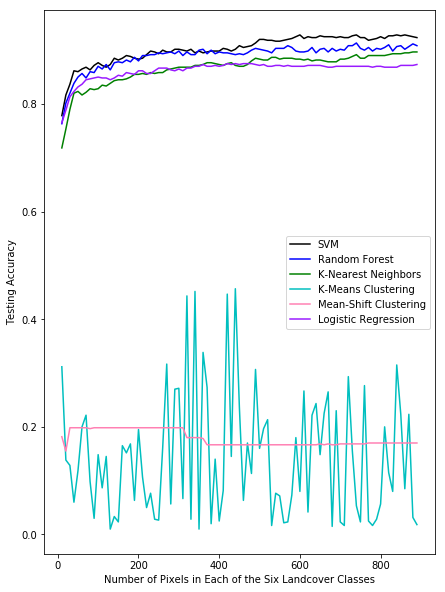

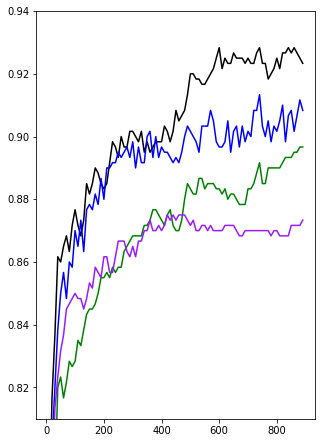

In [73]:
%matplotlib inline 
plt.figure(num = 1, figsize = (7,10));
plt.plot(max_count_per,svm_scores,'k',label = 'SVM')
plt.plot(max_count_per, rfc_scores,'b', label = 'Random Forest')
plt.plot(max_count_per, knn_scores, 'g', label = 'K-Nearest Neighbors')
plt.plot(max_count_per, k_means_scores,'c', label= 'K-Means Clustering')
plt.plot(max_count_per, mean_shift_scores, color = [1,0.5,0.7],label = 'Mean-Shift Clustering')
plt.plot(max_count_per, logreg_scores,color = [0.6,0.1,1],label = 'Logistic Regression')
plt.legend()
# plt.yticks([0,0.1, 0.2, 0.3, 0.4,0.5,1.0])
# plt.ylim([0,1])
plt.xlabel('Number of Pixels in Each of the Six Landcover Classes')
plt.ylabel('Testing Accuracy')
# plt.title('0 to 1000')
plt.savefig('Sample_size_test.png',dpi = 1000)

plt.figure(num = 2, figsize = (5,7.5))
plt.plot(max_count_per,svm_scores,'k',label = 'SVM')
plt.plot(max_count_per, rfc_scores,'b', label = 'Random Forest')
plt.plot(max_count_per, knn_scores, 'g', label = 'K-Nearest Neighbors')
plt.plot(max_count_per, logreg_scores,color = [0.6,0.1,1],label = 'Logistic Regression')
# plt.legend()
# plt.xlabel('Number of Pixels in Each of the Six Landcover Classes')
# plt.ylabel('Testing Accuracy')
# plt.title('0 to 1000')
plt.ylim([0.81,0.94])
plt.savefig('Sample_size_test_zoom.png', dpi = 1000)


In [10]:
# Split
max_per_test_class = 100
max_per_train_class = 600

sk_data_train, sk_labels_train, sk_data_test, sk_labels_test, train_class_count_dict,test_class_count_dict = sk_train_test_split(max_per_test_class, max_per_train_class, sk_data, sk_labels)

# Data Prep
landcover_train = sk_labels_train[:,0]
canopy_train = sk_labels_train[:,1]
tiles_train = sk_data_train

landcover_test = sk_labels_test[:,0]
canopy_test = sk_labels_test[:,1]
tiles_test = sk_data_test



## Landcover Individual Model Testing and Parameter Tuning

### SVM

In [11]:
# Grid Search
SVC_parameters = {'kernel': ['linear','rbf','poly'],'C':[0.1, 0.5, 1, 5, 10], 'degree': [1,2,3,4,5], 'gamma': [0.1, 0.01, 0.001, 0.0001]}
SVC_grid = GridSearchCV(SVC(),SVC_parameters,cv = 10, scoring = 'accuracy' ) # might not work, might have to change back to CLF
SVC_grid.fit(tiles_train,landcover_train.astype('int'))

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 0.5, 1, 5, 10], 'degree': [1, 2, 3, 4, 5],
                         'gamma': [0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [12]:
# Best Paramaters
SVC_grid.best_params_

{'C': 10, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [13]:
# Gamma testing 
gamma_range = []
count = 0.05
while count < 1:
    gamma_range.append(count)
    count = count + 0.05
    
scores_gamma = []
for n in gamma_range:
    svm_test = svm.SVC(kernel = 'rbf', C = 10, gamma = n, degree = 1)
    svm_test.fit(tiles_train,landcover_train.astype('int'))
    pred_svm_test = svm_test.predict(tiles_test)
    scores_gamma.append(accuracy_score(landcover_test.astype('int'), pred_svm_test))

In [14]:
# Final SVM Model
clf = svm.SVC(kernel = 'rbf', C = 10, gamma = 0.1, degree = 1)
clf.fit(tiles_train,landcover_train.astype('int'))
pred_clf = clf.predict(tiles_test)
print('Classification Report')
print(classification_report(landcover_test.astype('int'), pred_clf))
print('Confusion Matrix')
print(confusion_matrix(landcover_test.astype('int'), pred_clf))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       100
           1       0.93      0.91      0.92       100
           2       0.94      0.98      0.96       100
           3       0.91      0.91      0.91       100
           4       0.85      0.85      0.85       100
           5       0.95      0.94      0.94       100

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600

Confusion Matrix
[[98  0  0  0  2  0]
 [ 0 91  0  0  9  0]
 [ 0  0 98  2  0  0]
 [ 0  0  3 91  3  3]
 [ 1  7  3  2 85  2]
 [ 0  0  0  5  1 94]]


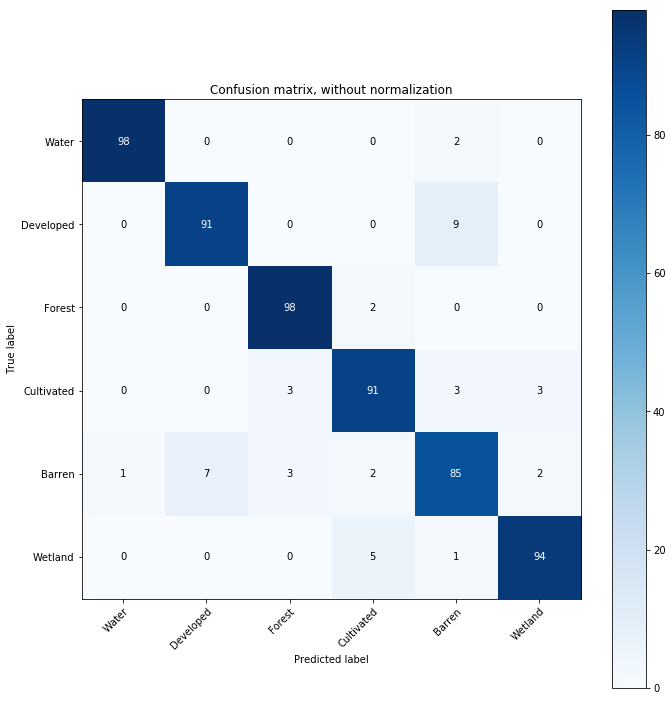

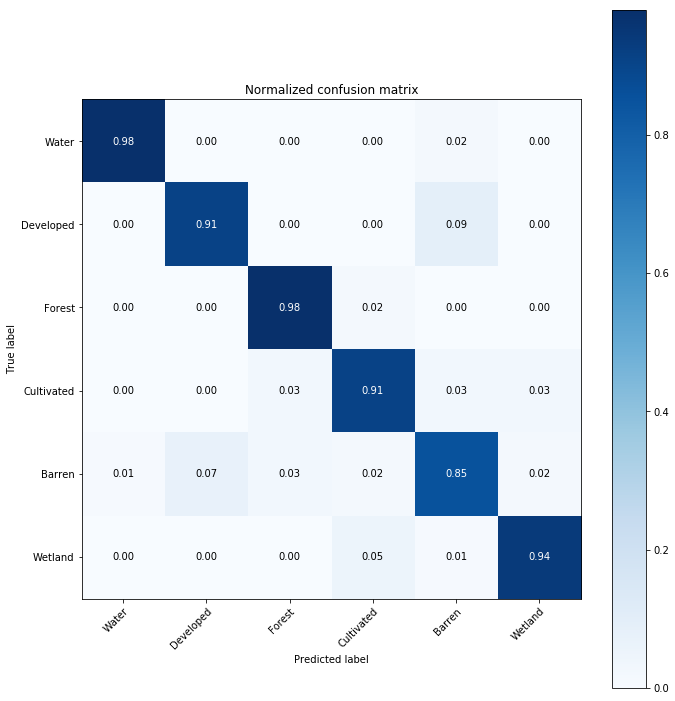

In [15]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
util.plot_confusion_matrix(landcover_test.astype('int'), pred_clf, classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary)
# Plot normalized confusion matrix
util.plot_confusion_matrix(landcover_test.astype('int'), pred_clf, classes=np.array(list(util.indexed_dictionary)),
                      class_dict=util.indexed_dictionary,
                      normalize=True)

# count = 0
# for i in range(len(landover_test)):
#     if(label_index[i] == pred_index[i]):
#         count+=1
# print("Accuracy is {}".format(count/len(label_index)))

plt.savefig("confusion_matrix.png", dpi=1000)

### RFC 

In [17]:
# Grid Search
rfc = RandomForestClassifier()
RFC_parameters = { 
    'n_estimators': [180],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,11,12,13,14,15],
    'criterion' :['gini', 'entropy']
}
RFC_grid = GridSearchCV(rfc,RFC_parameters,cv = 10, scoring = 'accuracy' )
RFC_grid.fit(tiles_train,landcover_train.astype('int'))

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [18]:
# Best Parameters
RFC_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 13,
 'max_features': 'log2',
 'n_estimators': 180}

In [19]:
# RFC Neighbor Testing
n_range = range(1,1000,10)
scores_n = []
for n in n_range:
    rfc_test = RandomForestClassifier(criterion = 'entropy', max_depth = 11, max_features = 'auto', n_estimators = n)
    rfc_test.fit(tiles_train, landcover_train.astype('int'))
    pred_rfc_test = rfc_test.predict(tiles_test)
    scores_n.append(accuracy_score(landcover_test.astype('int'), pred_rfc_test))

Text(0.5, 1.0, '100 to 300')

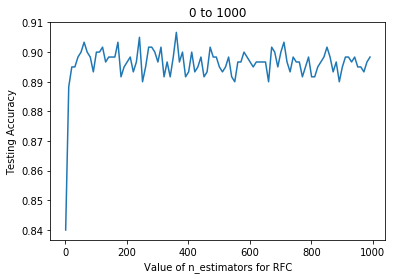

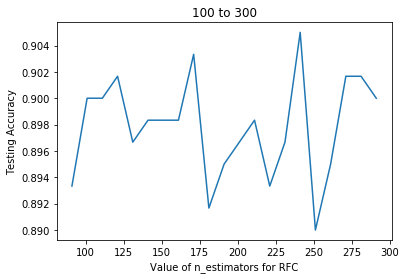

In [20]:
# RFC Testing Plot
%matplotlib inline 
plt.figure(1);
plt.plot(n_range,scores_n)
plt.xlabel('Value of n_estimators for RFC')
plt.ylabel('Testing Accuracy')
plt.title('0 to 1000')

plt.figure(2)
plt.plot(n_range[9:30],scores_n[9:30])
plt.xlabel('Value of n_estimators for RFC')
plt.ylabel('Testing Accuracy')
plt.title('100 to 300')

In [21]:
# Final RFC Model
rfc = RandomForestClassifier(criterion = 'entropy', max_depth = 11, max_features = 'auto', n_estimators = 180)
rfc.fit(tiles_train,landcover_train.astype('int'))
pred_rfc = rfc.predict(tiles_test)
print('Classification Report')
print(classification_report(landcover_test.astype('int'), pred_rfc))
print('Confusion Matrix')
print(confusion_matrix(landcover_test.astype('int'), pred_rfc))


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       100
           1       0.84      0.91      0.87       100
           2       0.92      0.98      0.95       100
           3       0.87      0.90      0.88       100
           4       0.85      0.66      0.74       100
           5       0.92      0.95      0.94       100

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600

Confusion Matrix
[[99  0  0  0  1  0]
 [ 0 91  0  0  9  0]
 [ 0  0 98  2  0  0]
 [ 0  0  5 90  2  3]
 [ 1 17  4  7 66  5]
 [ 0  0  0  5  0 95]]


### KNN (Landcover)

In [22]:
# KNN Neighbor Testing
k_range = range(1,100)
scores = []
for k in k_range:
    knn_test = KNeighborsClassifier(n_neighbors = k)
    knn_test.fit(tiles_train,landcover_train.astype('int'))
    pred_knn_test = knn_test.predict(tiles_test)
    scores.append(accuracy_score(landcover_test.astype('int'),pred_knn_test))
    

Text(0.5, 1.0, '15 to 35')

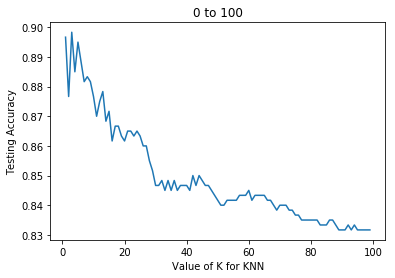

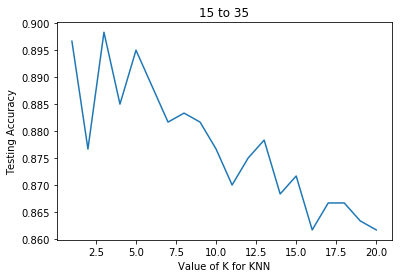

In [23]:
# KNN Testing Plot
%matplotlib inline 
plt.figure(1);
plt.plot(k_range,scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.title('0 to 100')


plt.figure(2);
plt.plot(k_range[0:20],scores[0:20])
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.title('15 to 35')

In [24]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(tiles_train,landcover_train.astype('int'))
pred_knn = knn.predict(tiles_test)
print('Classification Report')
print(classification_report(landcover_test.astype('int'), pred_knn))
print('Confusion Matrix')
print(confusion_matrix(landcover_test.astype('int'), pred_knn))

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       100
           1       0.79      0.96      0.86       100
           2       0.86      0.98      0.92       100
           3       0.91      0.90      0.90       100
           4       0.89      0.55      0.68       100
           5       0.90      0.91      0.91       100

    accuracy                           0.88       600
   macro avg       0.89      0.88      0.88       600
weighted avg       0.89      0.88      0.88       600

Confusion Matrix
[[100   0   0   0   0   0]
 [  0  96   0   0   4   0]
 [  0   0  98   2   0   0]
 [  0   0   3  90   2   5]
 [  2  26   9   3  55   5]
 [  0   0   4   4   1  91]]


### Logistic Regression

In [75]:
logreg = LogisticRegression()
logreg.fit(tiles_train,landcover_train.astype('int'))
pred_logreg = logreg.predict(tiles_test)
print('Classification Report')
print(classification_report(landcover_test.astype('int'), pred_logreg))
print('Confusion Matrix')
print(confusion_matrix(landcover_test.astype('int'), pred_logreg))

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       100
           1       0.82      0.82      0.82       100
           2       0.88      0.98      0.93       100
           3       0.86      0.90      0.88       100
           4       0.78      0.63      0.70       100
           5       0.92      0.91      0.91       100

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600

Confusion Matrix
[[100   0   0   0   0   0]
 [  0  82   0   1  17   0]
 [  0   0  98   1   0   1]
 [  0   1   5  90   1   3]
 [  3  17   6   7  63   4]
 [  1   0   2   6   0  91]]


### K-means

In [25]:
k_means = KMeans(n_clusters = 6)
k_means.fit(tiles_train,landcover_train.astype('int'))
pred_k_means = k_means.predict(tiles_test)
print('Classification Report')
print(classification_report(landcover_test.astype('int'), pred_k_means))
print('Confusion Matrix')
print(confusion_matrix(landcover_test.astype('int'), pred_k_means))

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.23      0.05      0.08       100
           2       0.01      0.02      0.01       100
           3       0.00      0.00      0.00       100
           4       0.43      0.35      0.39       100
           5       0.00      0.00      0.00       100

    accuracy                           0.07       600
   macro avg       0.11      0.07      0.08       600
weighted avg       0.11      0.07      0.08       600

Confusion Matrix
[[  0   0   0 100   0   0]
 [  2   5  51   0  42   0]
 [ 98   0   2   0   0   0]
 [  9   0  87   0   4   0]
 [ 12  17  32   4  35   0]
 [ 85   0   6   9   0   0]]


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Mean Shift

In [26]:
mean_shift = MeanShift()
mean_shift.fit(tiles_train,landcover_train.astype('int'))
pred_mean_shift = mean_shift.predict(tiles_test)
print('Classification Report')
print(classification_report(landcover_test.astype('int'), pred_mean_shift))
print('Confusion Matrix')
print(confusion_matrix(landcover_test.astype('int'), pred_mean_shift))

Classification Report
              precision    recall  f1-score   support

           0       0.18      1.00      0.31       100
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.00      0.00      0.00       100
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.17       600
   macro avg       0.02      0.12      0.04       600
weighted avg       0.03      0.17      0.05       600

Confusion Matrix
[[100   0   0   0   0   0   0   0]
 [ 86   0   0   0   0   0   7   7]
 [100   0   0   0   0   0   0   0]
 [ 98   0   0   0   0   0   0   2]
 [ 64   0   0   0   0   0  16  20]
 [100   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Visualization with Best Model (SVM)

### Data Generation for Map

In [107]:

all_pix = rnn_pixels.make_pixels(1, ['028011'], shuffle=False)

row_start = 5000 * 3500
row_end = 5000 * 4000

width = 5000 # pixels
height = int((row_end - row_start) / 5000) # pixels

height

KeyboardInterrupt: 

In [78]:
sk_data, sk_labels, pixels = rnn_pixels.all_pix_data(landsat_datasets, lc_labels, canopy_labels, ['028011'], class_count, row_start, row_end)
sk_data.shape, sk_labels.shape, np.array(pixels).shape

Beginning data creation.
Pix generated, starting generator.
Processing Complete.


((2500000, 28), (2500000, 2), (2500000, 2))

### Fit SVM

In [80]:
# Fit SVM
predictions = clf.predict(sk_data)

### Reshape Data Based on the Dimensions Used to Generate it 

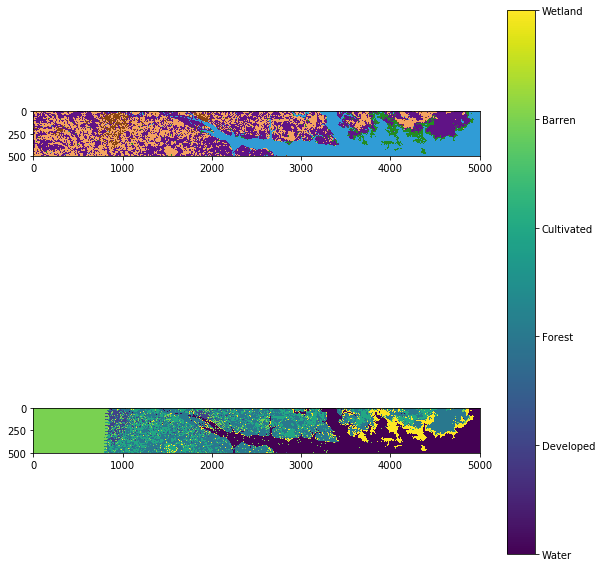

In [136]:
predictions_img = predictions.reshape(height,width)

fig, ax = plt.subplots(2,1,figsize=(10,10))

# Graph Original
sk_labels_int = sk_labels[:,0].astype('int')
original_img = sk_labels_int.reshape(height,width)
# Create Color Map
# find the highest pixel value in the prediction image
n = int(np.max(predictions_img))

# next setup a colormap for our map
colors = dict((
    (0, (48, 156, 214, 255)),   # Blue - Water
    (1, (139,69,19, 255)),      # Brown - WetSand
    (2, (96, 19, 134, 255)),    # Purple - Emergent Wetland
    (3, (244, 164, 96, 255)),   # Tan - Sand
    (4, (206, 224, 196, 255)),  # Lime - Herbaceous
    (5, (34, 139, 34, 255)),    # Forest Green - Forest 
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

img_org = ax[0].imshow(original_img, cmap= cmap) # (original_img, cmap = cmap, interpolation = 'none')

# Graph Predicitons
img = ax[1].imshow(predictions_img, cmap='viridis')
cb = fig.colorbar(img,ax = ax)
cb.ax.set_yticklabels(['Water', 'Developed', 'Forest', 'Cultivated', 'Barren', 'Wetland'])
fig.show()


In [112]:
# original_img = sk_labels[:,0].reshape(height,width)
# img = ax.imshow(predictions_img, cmap='viridis')
# cb = fig.colorbar(img,ax = ax)
# cb.ax.set_yticklabels(['Water', 'Developed', 'Forest', 'Cultivated', 'Barren', 'Wetland'])
# fig.show()

## Adding Landcover to Training Data

In [27]:
landcover_train_altered =[10,10,10,10,10,10]
for x in landcover_train:
    adding = [0,0,0,0,0,0]
    adding[x] = 1
    landcover_train_altered = np.vstack([landcover_train_altered,adding])

landcover_test_altered =[10,10,10,10,10,10]
for x in landcover_test:
    adding = [0,0,0,0,0,0]
    adding[x] = 1
    landcover_test_altered = np.vstack([landcover_test_altered,adding])


landcover_train_altered = landcover_train_altered[1:]
landcover_test_altered = landcover_test_altered[1:]

new_tiles_train = np.concatenate((tiles_train,landcover_train_altered), axis = 1)
new_tiles_test = np.concatenate((tiles_test, landcover_test_altered), axis = 1)
new_tiles_train.shape, new_tiles_test.shape

((3600, 34), (600, 34))

In [28]:
landcover_train_altered =[100]
for x in landcover_train:
    adding = [x]
    landcover_train_altered = np.vstack([landcover_train_altered,adding])

landcover_test_altered =[100]
for x in landcover_test:
    adding = [x]
    landcover_test_altered = np.vstack([landcover_test_altered,adding])


landcover_train_altered = landcover_train_altered[1:]
landcover_test_altered = landcover_test_altered[1:]

new_tiles_train2 = np.concatenate((tiles_train,landcover_train_altered), axis = 1)
new_tiles_test2 = np.concatenate((tiles_test, landcover_test_altered), axis = 1)
new_tiles_train2.shape, new_tiles_test2.shape

((3600, 29), (600, 29))

## Linear Regression (Canopy)

#### Normal Training Tiles

Mean Absolute Error: 0.13088866061235835
Mean Squared Error: 0.028646518065252303
Root Mean Squared Error: 0.16925282291664237


Text(0.5, 1.0, 'Linear Regression')

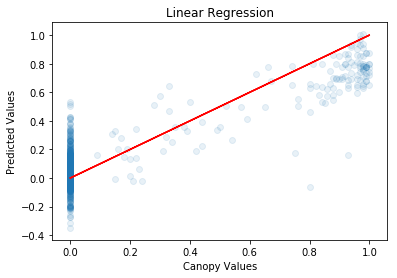

In [29]:
LR = LinearRegression()
LR.fit(tiles_train,canopy_train)
predLR = LR.predict(tiles_test)

print('Mean Absolute Error:',metrics.mean_absolute_error(canopy_test, predLR))
print('Mean Squared Error:',metrics.mean_squared_error(canopy_test, predLR))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(canopy_test,predLR)))

%matplotlib inline 
plt.figure(1);
plt.scatter(canopy_test, predLR, alpha = .1)
plt.plot(canopy_test, canopy_test,color = 'r')
plt.xlabel('Canopy Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression')

#### Training Tiles With Landcover Data

In [30]:
LR_landcover = LinearRegression()
LR_landcover.fit(new_tiles_train,canopy_train)
predLR_landcover = LR.predict(new_tiles_test)

print('Mean Absolute Error:',metrics.mean_absolute_error(canopy_test, predLR_landcover))
print('Mean Squared Error:',metrics.mean_squared_error(canopy_test, predLR_landcover))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(canopy_test,predLR_landcover)))

%matplotlib inline 
plt.figure(1);
plt.scatter(canopy_test, predLR_landcover, alpha = .1)
plt.plot(canopy_test, canopy_test,color = 'r')
plt.xlabel('Canopy Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression')

ValueError: shapes (600,34) and (28,) not aligned: 34 (dim 1) != 28 (dim 0)

## Lasso (Canopy)

In [ ]:
las= Lasso(alpha = 0.05)
las.fit(tiles_train,canopy_train)
predLas = las.predict(tiles_test)


print('Mean Absolute Error:',metrics.mean_absolute_error(canopy_test, predLas))
print('Mean Squared Error:',metrics.mean_squared_error(canopy_test, predLas))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(canopy_test, predLas)))

%matplotlib inline 
plt.figure(1);
plt.scatter(canopy_test, predLas)
plt.plot(canopy_test, canopy_test,color = 'r')
plt.xlabel('Canopy Values')
plt.ylabel('Predicted Values')
plt.title('Lasso')

## Random Forest Regression

#### Normal Training Tiles

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(tiles_train,canopy_train)
pred_rfr = rfr.predict(tiles_test)

print('Mean Absolute Error:',metrics.mean_absolute_error(canopy_test, pred_rfr))
print('Mean Squared Error:',metrics.mean_squared_error(canopy_test, pred_rfr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(canopy_test,pred_rfr)))

%matplotlib inline 
plt.figure(1);
plt.scatter(canopy_test, pred_rfr, alpha = .1)
plt.plot(canopy_test, canopy_test,color = 'r')
plt.xlabel('Canopy Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression')

#### Training Tiles With Landcover Data

In [ ]:
rfr_landcover = RandomForestRegressor()
rfr_landcover.fit(new_tiles_train,canopy_train)
pred_rfr_landcover = rfr_landcover.predict(new_tiles_test)

print('Mean Absolute Error:',metrics.mean_absolute_error(canopy_test, pred_rfr_landcover))
print('Mean Squared Error:',metrics.mean_squared_error(canopy_test, pred_rfr_landcover))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(canopy_test,pred_rfr_landcover)))

%matplotlib inline 
plt.figure(1);
plt.scatter(canopy_test, pred_rfr_landcover, alpha = .1)
plt.plot(canopy_test, canopy_test,color = 'r')
plt.xlabel('Canopy Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression')